# Fine-tuning

Usefull Imports:

In [1]:
from dataset import FireDataset, Patches
from transforms import training_transforms, test_transforms
from utils import load_config

from einops import rearrange
import torch
import yaml
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

Path to the pre-trained model and the associated config:

In [ ]:
config_path = "Pretrained_models/mae_20250217_183725/config.yaml"
chkpt_path = "Pretrained_models/mae_20250217_183725/checkpoints/best_loss.pt"

### Data loading

In [2]:
with open(config_path, 'r') as stream:
    config = load_config(yaml.safe_load(stream))

In [3]:
#see train dataset
transforms = training_transforms(config["transforms"])
dataset = FireDataset("data/",dataset = "train", transform = transforms)

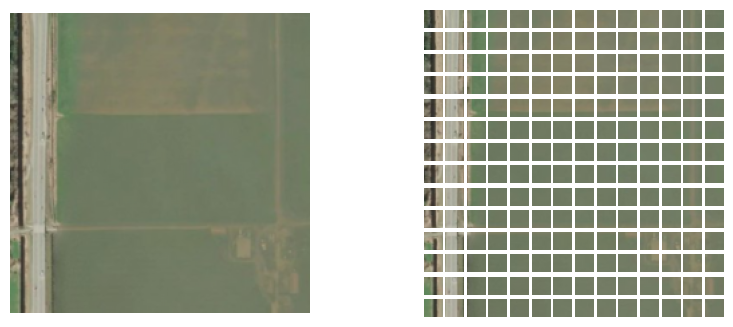

In [4]:
patches = Patches(dataset, config["pre-training"]["n_patches"])
patches.show_random(1)

## Reconstruction Inference

In [5]:
from models import init_model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
torch.cuda.empty_cache()

In [8]:
mae = init_model('mae', 'transformer', 'transformer', config = config).to('cpu')
    
checkpoint = torch.load(chkpt_path, map_location=torch.device('cpu'))
mae.load_state_dict(checkpoint["model_state_dict"])
mae.eval()

MAE(
  (patch_encoding): PatchEncoding(
    (projection): Linear(in_features=768, out_features=1024, bias=True)
  )
  (encoder): TransformerEncoder(
    (encoder_layers): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (linear1): Linear(in_features=1024, out_features=6144, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=6144, out_features=1024, bias=True)
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDeco

In [9]:
transfo = test_transforms(config['transforms'])
test_set = FireDataset("data/",dataset = "test", transform = transforms)
mini_set = test_set.get_mini_set(20)
patches_test = Patches(mini_set, config["pre-training"]["n_patches"])

test_loader = DataLoader(patches_test, batch_size=1, shuffle=False)

Inference for reconstruction:

In [10]:
patches_images = []
orig_images = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        image, patches, _ = batch
        
        patches = patches.to('cpu')
        
        pred, _ = mae(patches, return_masked = True)
        
        patches_images.append(pred)
        orig_images.append(patches)

  0%|          | 0/20 [00:00<?, ?it/s]

Visualization of the results:

In [11]:
def reconstruct_from_patches(image, std, mean):
    
    n_patches, C, H, W = image.shape
    pp_image = rearrange(image, "n c h w -> n h w c")
    
    pp_image = pp_image * std + mean
    pp_image = np.clip(pp_image,0, 1)
    
    n_patches_dim = int(np.sqrt(n_patches))
    
    reconstruct_image = np.zeros((H*n_patches_dim, W*n_patches_dim, C))
    
    for i in range(n_patches_dim):
        for j in range(n_patches_dim):
            patch_idx = i * n_patches_dim + j
            reconstruct_image[i * H: (i + 1) * H, j * W: (j + 1) * W, :] = pp_image[patch_idx]

    return reconstruct_image

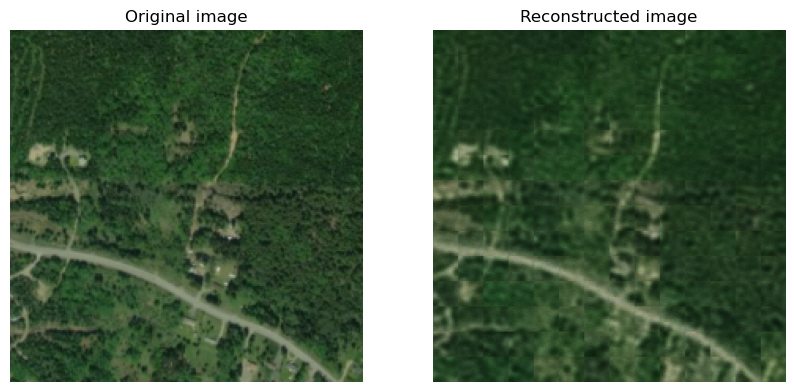

In [12]:
idx = 1
test = patches_images[idx]
orig_test = orig_images[idx]
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

result = reconstruct_from_patches(test.cpu().numpy()[0], mean, std)
orig = reconstruct_from_patches(orig_test.cpu().numpy()[0], mean, std)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result)
plt.title("Reconstructed image")
plt.axis('off')

plt.show()

## Classification task

Model definition:

In [13]:
class ClassificationModel(nn.Module):
    def __init__(self,patch_encoding, encoder, embedding_dim, freeze_encoder = True):
        super(ClassificationModel, self).__init__()
        self.patch_encoding = patch_encoding
        
        self.patch_encoding.mask_proportion = 0
         
        self.encoder = encoder
        self.freeze_encoder = freeze_encoder
        
        if freeze_encoder:
            for param in self.patch_encoding.parameters():
                param.requires_grad = False
            for param in self.encoder.parameters():
                param.requires_grad = False
            
            self.patch_encoding.eval()
            self.encoder.eval()

        #classification head
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  
            nn.BatchNorm1d(embedding_dim),
            nn.Linear(embedding_dim, 1)
        )

    def forward(self, x):
        
        if self.freeze_encoder:
            with torch.no_grad():  
                patches = self.patch_encoding(x)[0]
                embeddings = self.encoder(patches)
        else:
            patches = self.patch_encoding(x)[0]
            embeddings = self.encoder(patches)

        pooled_embeddings = torch.mean(embeddings, dim=1)
        logits = self.classifier(pooled_embeddings)
        return logits

We use the pre-trained encoders for our classification model:

In [16]:
patch_encoding = mae.patch_encoding
encoder = mae.encoder

#whether the encoders will be frozen or not
freeze_encoder= False

model = ClassificationModel(patch_encoding, encoder, 1024, freeze_encoder).to(device)

In [17]:
dataset = FireDataset("data/",dataset = "valid", transform = transforms)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

patches_train = Patches(train_dataset, config["pre-training"]["n_patches"])
patches_val = Patches(val_dataset, config["pre-training"]["n_patches"])


train_loader = DataLoader(patches_train, batch_size=16, shuffle=True)
val_loader = DataLoader(patches_val, batch_size=16, shuffle=True)

### Fine-tuning the model

In [29]:
if freeze_encoder:
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay= 1e-4)
else:
    optimizer = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': 1e-5, "weight_decay" : 1e-4},  
        {'params': model.classifier.parameters(), 'lr': 1e-3, "weight_decay" : 1e-4}  
    ])
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, patches, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        inputs = inputs.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, patches, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            inputs, patches, labels = inputs.to(device), patches.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(patches)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            preds = torch.sigmoid(outputs) >= 0.5  # Convert logits to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}")

Epoch 1 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 1, Loss: 0.08693623258565952


Epoch 1 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 0.1198, Validation Accuracy: 96.2698%


Epoch 2 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 2, Loss: 0.09023605493592128


Epoch 2 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 0.1206, Validation Accuracy: 96.2698%


Epoch 3 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 3, Loss: 0.08399442313534636


Epoch 3 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 0.1218, Validation Accuracy: 96.1111%


Epoch 4 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 4, Loss: 0.08381852552753001


Epoch 4 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 0.1313, Validation Accuracy: 96.1111%


Epoch 5 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0720818062287031


Epoch 5 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5, Validation Loss: 0.1512, Validation Accuracy: 95.7143%


Epoch 6 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0771608171574328


Epoch 6 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6, Validation Loss: 0.1195, Validation Accuracy: 96.3492%


Epoch 7 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 7, Loss: 0.07056380823949382


Epoch 7 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7, Validation Loss: 0.1216, Validation Accuracy: 96.5079%


Epoch 8 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 8, Loss: 0.06763766397101184


Epoch 8 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8, Validation Loss: 0.1358, Validation Accuracy: 95.9524%


Epoch 9 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 9, Loss: 0.06778755523818766


Epoch 9 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9, Validation Loss: 0.1380, Validation Accuracy: 96.1111%


Epoch 10 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 10, Loss: 0.05502001370103764


Epoch 10 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10, Validation Loss: 0.1733, Validation Accuracy: 96.1111%


### Inference

In [30]:
patches_test = Patches(test_set, config["pre-training"]["n_patches"])
test_loader = DataLoader(patches_test, batch_size=1, shuffle=False)

In [31]:
model.eval()  # Set the model to evaluation mode
correct, total = 0, 0

with torch.no_grad():  # Disable gradients for efficiency
    for inputs, patches, labels in tqdm(test_loader, desc="Testing"):
        inputs, patches, labels = inputs.to(device), patches.to(device), labels.to(device).float().view(-1, 1)

        outputs = model(patches)
        preds = torch.sigmoid(outputs) >= 0.5  # Convert logits to binary predictions (0 or 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4%}")

Testing:   0%|          | 0/6300 [00:00<?, ?it/s]

Premature end of JPEG file


Test Accuracy: 97.7778%


In [32]:
torch.save(model.state_dict(), 'model/model.pt')

## Simple classification model 

Model used as a comparison of the one using pre-trained encoder

In [44]:
class ClassificationModel(nn.Module):
    def __init__(self, embedding_dim):
        super(ClassificationModel, self).__init__()

        self.projection = nn.Linear(3 * 16 * 16 ,embedding_dim)
        
        #classification head
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  
            nn.BatchNorm1d(embedding_dim),
            nn.Linear(embedding_dim, 1)
        )

    def forward(self, x):

        x = rearrange(x, 'b n c h w -> b n (c h w)')
        
        embeddings = self.projection(x)

        pooled_embeddings = torch.mean(embeddings, dim=1)
        logits = self.classifier(pooled_embeddings)
        return logits

In [45]:
model = ClassificationModel(1024).to(device)

In [46]:
dataset = FireDataset("data/",dataset = "valid", transform = transforms)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

patches_train = Patches(train_dataset, config["pre-training"]["n_patches"])
patches_val = Patches(val_dataset, config["pre-training"]["n_patches"])


train_loader = DataLoader(patches_train, batch_size=16, shuffle=True)
val_loader = DataLoader(patches_val, batch_size=16, shuffle=True)

### Training

In [47]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay= 1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(30):
    model.train()
    running_loss = 0.0
    for inputs, patches, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
        inputs = inputs.to(device)
        patches = patches.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, patches, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
            inputs, patches, labels = inputs.to(device), patches.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(patches)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            preds = torch.sigmoid(outputs) >= 0.5  # Convert logits to binary predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}")

Epoch 1 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 1, Loss: 0.34647868736868814


Epoch 1 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 0.2822, Validation Accuracy: 88.6508%


Epoch 2 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 2, Loss: 0.32910414192648163


Epoch 2 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 0.2752, Validation Accuracy: 88.5714%


Epoch 3 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 3, Loss: 0.32464870104477517


Epoch 3 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 0.2840, Validation Accuracy: 88.7302%


Epoch 4 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 4, Loss: 0.31797268387107624


Epoch 4 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 0.2812, Validation Accuracy: 88.4921%


Epoch 5 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 5, Loss: 0.3236939504506096


Epoch 5 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5, Validation Loss: 0.2768, Validation Accuracy: 88.2540%


Epoch 6 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 6, Loss: 0.3309878925482432


Epoch 6 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6, Validation Loss: 0.2871, Validation Accuracy: 88.6508%


Epoch 7 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 7, Loss: 0.3377300167604098


Epoch 7 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7, Validation Loss: 0.2764, Validation Accuracy: 88.6508%


Epoch 8 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 8, Loss: 0.3168767021762


Epoch 8 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8, Validation Loss: 0.2757, Validation Accuracy: 88.8095%


Epoch 9 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 9, Loss: 0.32649262117014993


Epoch 9 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9, Validation Loss: 0.2797, Validation Accuracy: 89.2063%


Epoch 10 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 10, Loss: 0.32952841198633587


Epoch 10 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10, Validation Loss: 0.2970, Validation Accuracy: 88.1746%


Epoch 11 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 11, Loss: 0.32669950025895284


Epoch 11 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11, Validation Loss: 0.2759, Validation Accuracy: 88.9683%


Epoch 12 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 12, Loss: 0.3212254323538334


Epoch 12 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12, Validation Loss: 0.2773, Validation Accuracy: 88.3333%


Epoch 13 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 13, Loss: 0.32586220817433464


Epoch 13 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13, Validation Loss: 0.2818, Validation Accuracy: 88.9683%


Epoch 14 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 14, Loss: 0.3227622768117322


Epoch 14 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14, Validation Loss: 0.2899, Validation Accuracy: 88.3333%


Epoch 15 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 15, Loss: 0.32574890913471344


Epoch 15 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15, Validation Loss: 0.2778, Validation Accuracy: 88.9683%


Epoch 16 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 16, Loss: 0.32504531570843287


Epoch 16 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16, Validation Loss: 0.2795, Validation Accuracy: 88.8889%


Epoch 17 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 17, Loss: 0.3359212891923057


Epoch 17 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17, Validation Loss: 0.2765, Validation Accuracy: 88.7302%


Epoch 18 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 18, Loss: 0.32201549231059967


Epoch 18 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18, Validation Loss: 0.2790, Validation Accuracy: 88.3333%


Epoch 19 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 19, Loss: 0.31517123965516924


Epoch 19 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19, Validation Loss: 0.2856, Validation Accuracy: 88.6508%


Epoch 20 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 20, Loss: 0.3157236335946927


Epoch 20 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20, Validation Loss: 0.2805, Validation Accuracy: 89.0476%


Epoch 21 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 21, Loss: 0.324578637949058


Epoch 21 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21, Validation Loss: 0.2835, Validation Accuracy: 88.5714%


Epoch 22 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 22, Loss: 0.3190837054380349


Epoch 22 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22, Validation Loss: 0.2823, Validation Accuracy: 88.0952%


Epoch 23 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 23, Loss: 0.32609402505414825


Epoch 23 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23, Validation Loss: 0.2811, Validation Accuracy: 88.8095%


Epoch 24 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 24, Loss: 0.3179721728203789


Epoch 24 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24, Validation Loss: 0.2843, Validation Accuracy: 88.4921%


Epoch 25 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 25, Loss: 0.30657634635766345


Epoch 25 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25, Validation Loss: 0.2826, Validation Accuracy: 88.8095%


Epoch 26 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 26, Loss: 0.3193361783429744


Epoch 26 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26, Validation Loss: 0.2800, Validation Accuracy: 88.7302%


Epoch 27 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 27, Loss: 0.3216903419958221


Epoch 27 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27, Validation Loss: 0.2893, Validation Accuracy: 88.8889%


Epoch 28 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 28, Loss: 0.32223896935345636


Epoch 28 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28, Validation Loss: 0.2786, Validation Accuracy: 88.7302%


Epoch 29 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 29, Loss: 0.31301932979434255


Epoch 29 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29, Validation Loss: 0.2763, Validation Accuracy: 88.7302%


Epoch 30 [Training]:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 30, Loss: 0.3260903093195151


Epoch 30 [Validation]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30, Validation Loss: 0.2787, Validation Accuracy: 88.5714%


In [48]:
patches_test = Patches(test_set, config["pre-training"]["n_patches"])
test_loader = DataLoader(patches_test, batch_size=1, shuffle=False)

### Inference

In [ ]:
model.eval()  # Set the model to evaluation mode
correct, total = 0, 0

with torch.no_grad():  # Disable gradients for efficiency
    for inputs, patches, labels in tqdm(test_loader, desc="Testing"):
        inputs, patches, labels = inputs.to(device), patches.to(device), labels.to(device).float().view(-1, 1)

        outputs = model(patches)
        preds = torch.sigmoid(outputs) >= 0.5  # Convert logits to binary predictions (0 or 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4%}")

Testing:   0%|          | 0/6300 [00:00<?, ?it/s]